### Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')
clients_monthly = pd.read_csv('../data/processed/clients_monthly.csv')

In [3]:
clients.columns


Index(['client_id', 'city', 'channel', 'promotor_id', 'frequency',
       'efficiency', 'efficiency_scaled', 'total_orders', 'total_volume',
       'total_income', 'total_cost', 'total_profit', 'median_ticket',
       'median_ticket_min', 'median_ticket_max', 'median_ticket_std',
       'median_promotor_visits', 'total_promotor_visits',
       'median_promotor_calls', 'total_promotor_calls', 'class',
       'zero_visit_flag', 'avg_orders_per_month', 'avg_visits_per_month',
       'visit_order_gap', 'inefficiency_cost', 'profit_per_visit',
       'opportunity_cost'],
      dtype='object')

### Efficiency Distribution

In [4]:
# Update efficient_clients and inefficient_clients with the encoded dataframe
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

total_clients = len(clients)
num_efficient = len(efficient_clients)
num_inefficient = len(inefficient_clients)
pct_efficient = num_efficient / total_clients * 100
pct_inefficient = num_inefficient / total_clients * 100

print(f"Number of efficient clients: {num_efficient} ({pct_efficient:.1f}%)")
print(f"Number of inefficient clients: {num_inefficient} ({pct_inefficient:.1f}%)")

inefficient_clients['class'].value_counts()


Number of efficient clients: 34273 (81.7%)
Number of inefficient clients: 7677 (18.3%)


class
HighTicket_Inefficient    4137
LowTicket_Inefficient     3540
Name: count, dtype: int64

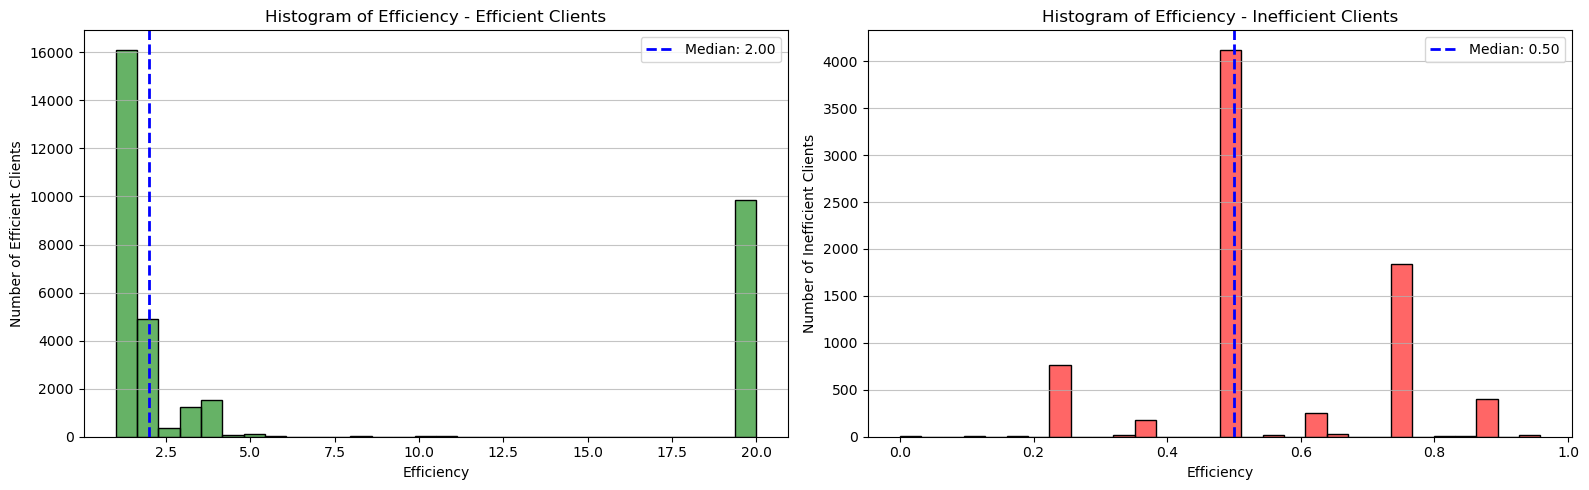

In [5]:
# Plot histograms of efficiency for efficient and inefficient clients side by side, marking the median
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Efficient Clients
sns.histplot(efficient_clients['efficiency'], bins=30, color='green', edgecolor='black', alpha=0.6, ax=axes[0])
median_efficient = efficient_clients['efficiency'].median()
axes[0].axvline(median_efficient, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_efficient:.2f}')
axes[0].set_title('Histogram of Efficiency - Efficient Clients')
axes[0].set_xlabel('Efficiency')
axes[0].set_ylabel('Number of Efficient Clients')
axes[0].grid(axis='y', alpha=0.75)
axes[0].legend()

# Inefficient Clients
sns.histplot(inefficient_clients['efficiency'], bins=30, color='red', edgecolor='black', alpha=0.6, ax=axes[1])
median_inefficient = inefficient_clients['efficiency'].median()
axes[1].axvline(median_inefficient, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_inefficient:.2f}')
axes[1].set_title('Histogram of Efficiency - Inefficient Clients')
axes[1].set_xlabel('Efficiency')
axes[1].set_ylabel('Number of Inefficient Clients')
axes[1].grid(axis='y', alpha=0.75)
axes[1].legend()

plt.tight_layout()
plt.show()


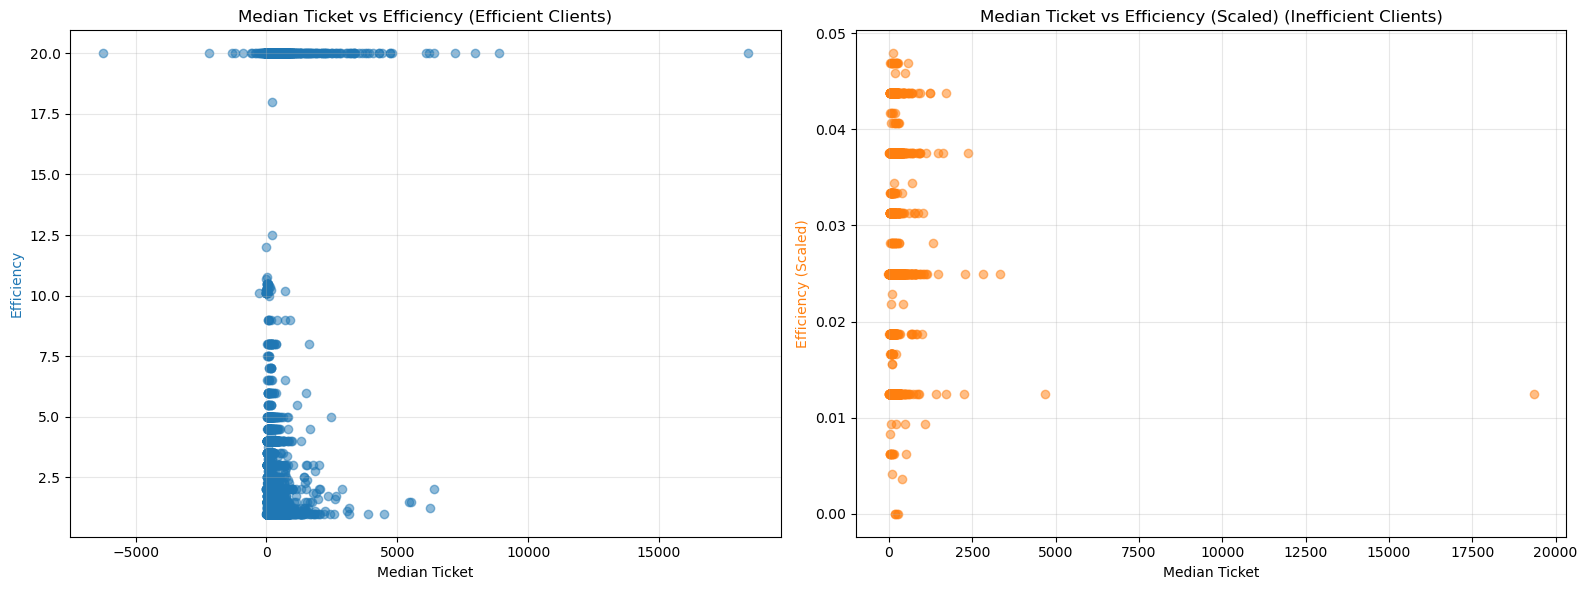

In [6]:
# Plot side by side: Efficiency vs Median Ticket (Efficient) and Efficiency (Scaled) vs Median Ticket (Inefficient)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Efficient clients
axes[0].scatter(efficient_clients['median_ticket'], efficient_clients['efficiency'], alpha=0.5, color='tab:blue', label='Efficiency')
axes[0].set_xlabel('Median Ticket')
axes[0].set_ylabel('Efficiency', color='tab:blue')
axes[0].set_title('Median Ticket vs Efficiency (Efficient Clients)')
axes[0].grid(True, alpha=0.3)

# Right plot: Inefficient clients
axes[1].scatter(inefficient_clients['median_ticket'], inefficient_clients['efficiency_scaled'], alpha=0.5, color='tab:orange', label='Efficiency (Scaled)')
axes[1].set_xlabel('Median Ticket')
axes[1].set_ylabel('Efficiency (Scaled)', color='tab:orange')
axes[1].set_title('Median Ticket vs Efficiency (Scaled) (Inefficient Clients)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Step-wise Function

In [7]:
import statsmodels.api as sm
import pandas as pd

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection based on p-value.
    
    Returns:
        A tuple containing two lists: (selected_features, removed_features)
    """
    included = list(initial_list)
    removed = []  # Initialize a new list to track removed features

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.4f}'.format(best_feature, best_pval))
            # If a feature that was previously removed is added back, remove it from the removed list
            if best_feature in removed:
                removed.remove(best_feature)

        # backward step
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            # Add the removed feature to our tracking list
            if worst_feature not in removed:
                removed.append(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.4f}'.format(worst_feature, worst_pval))
        if not changed:
            break
            
    return included, removed # Return both the included and removed lists

### 1. Initial Cleaning and Target Creation


In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# clients.drop(columns=['efficiency', 'efficiency_scaled'], inplace=True)

# clients['efficiency'] = (clients['frequency']/clients['median_promotor_visits'])
# clients.loc[(clients['frequency'] == 0),'efficiency'] = 0    
# clients['efficiency'] = clients['efficiency'].replace([np.inf, -np.inf], np.inf)

# # Step 1: Separate finite and infinite values
# finite_mask = np.isfinite(clients['efficiency'])
# infinite_mask = ~finite_mask

# # Step 2: Scale only finite values
# scaler = MinMaxScaler()
# clients.loc[finite_mask, 'efficiency_scaled'] = scaler.fit_transform(clients.loc[finite_mask, ['efficiency']])

# # Step 3: Assign a fixed high score to infs (e.g., 1.5, or max(finite) + margin)
# inf_value = clients['efficiency_scaled'].max() + 0.5
# clients.loc[infinite_mask, 'efficiency_scaled'] = inf_value

# max_value = clients.loc[finite_mask, 'efficiency'].max()
# clients.loc[infinite_mask, 'efficiency'] = max_value


# --- 1. Initial Cleaning and Target Creation ---
# Clean inf and NaN values to prevent errors
# clients.loc[(clients['frequency'] == 0),'efficiency'] = 0    
clients.replace([np.inf, -np.inf], np.nan, inplace=True)
clients.fillna(0, inplace=True)
clients['high_ticket'] = clients['median_ticket'] > 80

# Create the target variable

clients['optimal_visits_per_month'] = 0.0
clients.loc[clients['efficiency'] >= 1, 'optimal_visits_per_month'] = clients.loc[clients['efficiency'] >= 1, 'median_promotor_visits']

### 2. Data Splitting and Preparation


In [9]:
# --- 2. Data Splitting and Preparation ---
# Separate clients into the two groups
efficient_clients = clients[clients['efficiency'] >= 1].copy()
inefficient_clients = clients[clients['efficiency'] < 1].copy()

# Define the target variable from the efficient group
target = "optimal_visits_per_month"

# Prepare data for splitting. We keep original columns needed for encoding.
X = efficient_clients.drop(columns=[target], errors='ignore')
y = efficient_clients[target]

# Split the EFFICIENT client data FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3. Feature Engineering (No Leakage)


In [10]:
# Calculate encoding maps from TRAINING data only
promotor_efficiency_map = X_train.groupby('promotor_id')['efficiency'].mean()
city_efficiency_map = X_train.groupby('city')['efficiency'].mean()

# Apply Target Encoding to all dataframes
for df in [X_train, X_test, inefficient_clients]:
    df['promotor_encoded'] = df['promotor_id'].map(promotor_efficiency_map)
    df['city_encoded'] = df['city'].map(city_efficiency_map)

# One-Hot Encode remaining categoricals
features_to_encode = ['channel']
X_train = pd.get_dummies(X_train, columns=features_to_encode, drop_first=True)
X_test = pd.get_dummies(X_test, columns=features_to_encode, drop_first=True)
inefficient_clients = pd.get_dummies(inefficient_clients, columns=features_to_encode, drop_first=True)

### 4. Final Cleaning and Column Alignment

In [11]:
# Fill any NaNs that resulted from mapping
train_mean_efficiency = X_train['efficiency'].mean()
for df in [X_train, X_test, inefficient_clients]:
    df['promotor_encoded'] = df['promotor_encoded'].fillna(train_mean_efficiency)
    df['city_encoded'] = df['city_encoded'].fillna(train_mean_efficiency)
    df.fillna(0, inplace=True) # Fill any other potential NaNs

# Convert any new boolean columns to integers
for df in [X_train, X_test, inefficient_clients]:
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)

# Define columns to drop: identifiers, leaky variables, and original categoricals
columns_to_drop_final = [
    'client_id', 'promotor_id', 'city','class', 'efficiency', 'efficiency_scaled',
    'median_promotor_visits', 'median_promotor_calls', 'avg_visits_per_month',
    'frequency', 'total_promotor_visits', 'zero_visit_flag','visit_order_gap',
    'inefficiency_cost', 'profit_per_visit', 'opportunity_cost'
]

# Drop columns from all dataframes
X_train = X_train.drop(columns=columns_to_drop_final, errors='ignore')
X_test = X_test.drop(columns=columns_to_drop_final, errors='ignore')
inefficient_clients_processed = inefficient_clients.drop(columns=columns_to_drop_final, errors='ignore')

# Align columns to ensure test/prediction sets match the training set
train_cols = X_train.columns
X_test = X_test.reindex(columns=train_cols).fillna(0)
inefficient_clients_processed = inefficient_clients_processed.reindex(columns=train_cols).fillna(0)

### 5. Step Wise Feature Selection

In [12]:
# The function now returns two values
selected_features, removed_features = stepwise_selection(X_train, y_train, verbose=True)

print("\n--- Final Selected Features ---")
print(selected_features)

print("\n--- Features Removed During Selection ---")
if removed_features:
    print(removed_features)
else:
    print("No features were removed.")

Add  total_promotor_calls           with p-value 0.0000
Add  avg_orders_per_month           with p-value 0.0000
Add  promotor_encoded               with p-value 0.0000
Add  total_cost                     with p-value 0.0000
Add  high_ticket                    with p-value 0.0000
Add  total_profit                   with p-value 0.0000
Add  total_income                   with p-value 0.0000
Add  median_ticket_max              with p-value 0.0000
Add  total_orders                   with p-value 0.0000
Add  city_encoded                   with p-value 0.0000
Add  total_volume                   with p-value 0.0000
Add  median_ticket_min              with p-value 0.0004
Add  median_ticket_std              with p-value 0.0000
Add  median_ticket                  with p-value 0.0000

--- Final Selected Features ---
['total_promotor_calls', 'avg_orders_per_month', 'promotor_encoded', 'total_cost', 'high_ticket', 'total_profit', 'total_income', 'median_ticket_max', 'total_orders', 'city_encoded', 

### 6. Final Model Training and Prediction ---


In [13]:
# --- 6. Final Model Training and Prediction ---
X_train_final = X_train[selected_features]
X_test_final = X_test[selected_features]
inefficient_X_final = inefficient_clients_processed[selected_features]

# Train the XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, random_state=42, n_jobs=-1)
xgb_reg.fit(X_train_final, y_train)

# Evaluate the model's performance
y_pred = xgb_reg.predict(X_test_final)
r2 = r2_score(y_test, y_pred)
print(f"\n--- Final Model Evaluation ---")
print(f"R-squared (R2) Score on Test Set: {r2:.4f}")

# Predict optimal visits for inefficient clients
inefficient_clients['predicted_optimal_visits'] = xgb_reg.predict(inefficient_X_final)
inefficient_clients['predicted_optimal_visits'] = inefficient_clients['predicted_optimal_visits'].clip(lower=1).round().astype(int)

inefficient_clients['optimal_visits_per_month'] = inefficient_clients['predicted_optimal_visits']
inefficient_clients['new_efficiency'] = inefficient_clients['frequency'] / inefficient_clients['predicted_optimal_visits']



--- Final Model Evaluation ---
R-squared (R2) Score on Test Set: 0.9879


### 7. Prediction Results

In [17]:
import pandas as pd

# --- 1. Calculate the Visit Gap ---
# inefficient_clients['order_gap'] = inefficient_clients['frequency'] - inefficient_clients['median_promotor_visits']
inefficient_clients['visits_saved'] = inefficient_clients['median_promotor_visits'] - inefficient_clients['predicted_optimal_visits']

# --- 2. Calculate Efficiency Improvement ---
# Efficiency improvement = new_efficiency - current efficiency
inefficient_clients['efficiency_improvement'] = inefficient_clients['new_efficiency'] - inefficient_clients['efficiency']

# --- 3. Rank by Efficiency Improvement ---
top_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=False)
bottom_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=True)

# --- 4. Display the Results ---
display_cols_ranked = [
    'client_id',
    'efficiency',
    'new_efficiency',
    'efficiency_improvement',
    'frequency',
    'median_promotor_visits',
    'predicted_optimal_visits',
    'visits_saved'
]


no_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] == 0]
with_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] > 0]
negative_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] < 0]

# Summary statistics
print("--- SUMMARY STATISTICS ---")
print(f"Total inefficient clients analyzed: {len(inefficient_clients)}")
print(f"Clients with improvement: {len(with_improvement)} ({len(with_improvement)/len(inefficient_clients)*100:.1f}%)")
print(f"Clients with no improvement: {len(no_improvement)} ({len(no_improvement)/len(inefficient_clients)*100:.1f}%)")
print(f"Clients with negative improvement: {len(negative_improvement)} ({len(negative_improvement)/len(inefficient_clients)*100:.1f}%)")

# --- 3. Analyze and Display the Savings Results ---
total_potential_savings = inefficient_clients['potential_savings'].sum()
print(f"Total Potential Savings by reducing visits to over-served clients: ${total_potential_savings:,.2f}")


# --- 5. Print Efficiency Improvement Metrics SPLIT BY HIGHTICKET ---
for high_ticket_value, label in zip([1, 0], ["HighTicket = True", "HighTicket = False"]):
    subset = inefficient_clients[inefficient_clients['high_ticket'] == high_ticket_value]
    mean_improvement = subset['efficiency_improvement'].mean()
    median_improvement = subset['efficiency_improvement'].median()
    max_improvement = subset['efficiency_improvement'].max()
    min_improvement = subset['efficiency_improvement'].min()
    std_improvement = subset['efficiency_improvement'].std()
    num_positive = (subset['efficiency_improvement'] > 0).sum()
    num_negative = (subset['efficiency_improvement'] < 0).sum()
    num_zero = (subset['efficiency_improvement'] == 0).sum()

    print(f"\n--- Efficiency Improvement Metrics ({label}) ---")
    # print(f"Mean improvement: {mean_improvement:.4f}")
    # print(f"Median improvement: {median_improvement:.4f}")
    # print(f"Max improvement: {max_improvement:.4f}")
    # print(f"Min improvement: {min_improvement:.4f}")
    # print(f"Std deviation: {std_improvement:.4f}")
    print(f"Number of clients with positive improvement: {num_positive}")
    print(f"Number of clients with negative improvement: {num_negative}")
    print(f"Number of clients with zero improvement: {num_zero}")



--- SUMMARY STATISTICS ---
Total inefficient clients analyzed: 7677
Clients with improvement: 2094 (27.3%)
Clients with no improvement: 5544 (72.2%)
Clients with negative improvement: 39 (0.5%)
Total Potential Savings by reducing visits to over-served clients: $53,250.00

--- Efficiency Improvement Metrics (HighTicket = True) ---
Number of clients with positive improvement: 1167
Number of clients with negative improvement: 22
Number of clients with zero improvement: 2947

--- Efficiency Improvement Metrics (HighTicket = False) ---
Number of clients with positive improvement: 927
Number of clients with negative improvement: 17
Number of clients with zero improvement: 2597


### New Efficiency Distribution

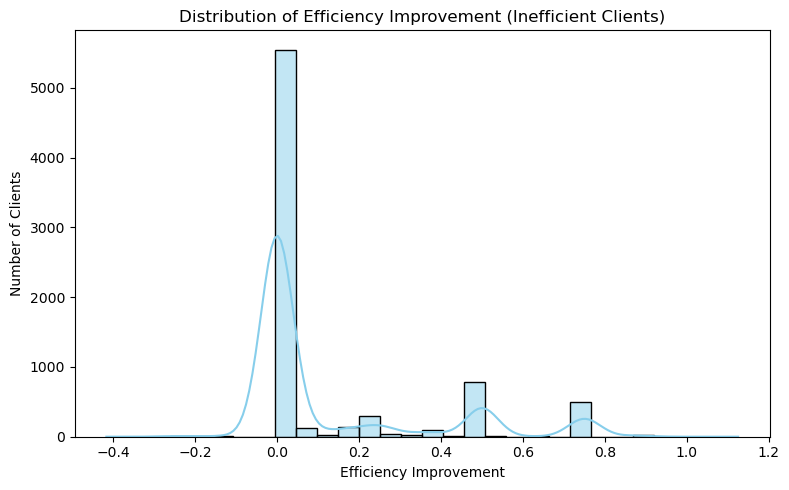

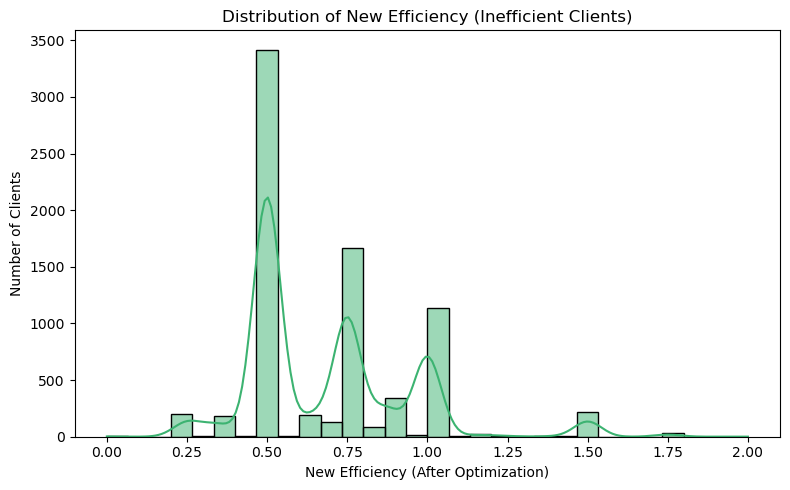


Top 10 inefficient clients with the highest efficiency improvement:


,client_id,new_efficiency,efficiency_improvement,visits_saved,median_promotor_visits,predicted_optimal_visits
14000,398954301,2.000000,1.125000,9.0,16.0,7
13806,394645783,1.916667,0.958333,6.0,12.0,6
21172,552834631,1.750000,0.875000,2.0,4.0,2
34283,837172592,1.750000,0.875000,2.0,4.0,2
16321,448102597,1.750000,0.875000,2.0,4.0,2
41246,985091868,1.750000,0.875000,2.0,4.0,2
25011,635722749,1.750000,0.875000,2.0,4.0,2
7097,253634335,1.750000,0.875000,2.0,4.0,2
16484,451769784,1.750000,0.875000,2.0,4.0,2
5494,218646581,1.500000,0.875000,3.0,4.0,1


In [15]:
# Display the results for inefficient clients: show key columns and summary statistics
import seaborn as sns
import matplotlib.pyplot as plt

# Fix: Use the correct column name for predicted optimal visits
display_cols = [
    'client_id', 'new_efficiency', 'efficiency_improvement','visits_saved',
    'median_promotor_visits', 'predicted_optimal_visits'
]

# --- Visualization 1: Distribution of efficiency improvement ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['efficiency_improvement'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Efficiency Improvement (Inefficient Clients)')
plt.xlabel('Efficiency Improvement')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Visualization 1b: Distribution of new efficiency ---
plt.figure(figsize=(8, 5))
sns.histplot(inefficient_clients['new_efficiency'], bins=30, kde=True, color='mediumseagreen')
plt.title('Distribution of New Efficiency (Inefficient Clients)')
plt.xlabel('New Efficiency (After Optimization)')
plt.ylabel('Number of Clients')
plt.tight_layout()
plt.show()

# --- Ranking: Top 10 most improved clients ---
print("\nTop 10 inefficient clients with the highest efficiency improvement:")
top_improved = inefficient_clients.sort_values('efficiency_improvement', ascending=False).head(10)
try:
    display(top_improved[display_cols])
except KeyError as e:
    print(f"KeyError: {e}")
    print("Available columns:", top_improved.columns.tolist())

### Savings

In [ ]:
import pandas as pd
import numpy as np

# --- 1. Estimate the Cost Per Visit ---
inefficient_clients['avg_cost_per_visit'] = (inefficient_clients['total_cost'] / inefficient_clients['total_promotor_visits']).replace([np.inf, -np.inf], 0).fillna(0)

# \--- 2. Calculate Potential Savings for Over-served Clients ---
inefficient_clients['potential_savings'] = 0.0
visit_cost = 15 #EUR per visit
inefficient_clients['potential_savings'] = inefficient_clients['visits_saved'] * visit_cost

# --- 3. Analyze and Display the Savings Results ---
total_potential_savings = inefficient_clients['potential_savings'].sum()
print(f"--- Cost-Saving Analysis ---")
print(f"Total Potential Savings by reducing visits to over-served clients: ${total_potential_savings:,.2f}")

# Rank the clients by the highest potential savings
top_savings_clients = inefficient_clients.sort_values('potential_savings', ascending=False)

# Define the columns for a clear report
display_cols_savings = [
'client_id',
'frequency',
'predicted_optimal_visits',
'visits_saved',
'potential_savings'
]

print("\n--- Top 10 Clients with the Highest Potential Savings ---")
display(top_savings_clients[display_cols_savings].head(10))

--- Cost-Saving Analysis ---
Total Potential Savings by reducing visits to over-served clients: $53,250.00

--- Top 10 Clients with the Highest Potential Savings ---


,client_id,frequency,predicted_optimal_visits,visits_saved,potential_savings
3357,171652774,2.0,7,21.0,315.0
14000,398954301,14.0,7,9.0,135.0
18498,495662597,9.0,8,8.0,120.0
6134,232310898,2.0,5,7.0,105.0
22566,583496858,1.0,2,6.0,90.0
13806,394645783,11.5,6,6.0,90.0
32481,796141173,1.0,2,6.0,90.0
29330,728786572,1.0,2,6.0,90.0
10030,315738125,1.0,2,6.0,90.0
19848,524084825,1.0,6,6.0,90.0


### Summary

In [28]:
import pandas as pd

# --- 1. Calculate the Visit Gap ---
# inefficient_clients['order_gap'] = inefficient_clients['frequency'] - inefficient_clients['median_promotor_visits']
inefficient_clients['visits_saved'] = inefficient_clients['median_promotor_visits'] - inefficient_clients['predicted_optimal_visits']

# --- 2. Calculate Efficiency Improvement ---
# Efficiency improvement = new_efficiency - current efficiency
inefficient_clients['efficiency_improvement'] = inefficient_clients['new_efficiency'] - inefficient_clients['efficiency']

# --- 3. Rank by Efficiency Improvement ---
top_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=False)
bottom_opportunities = inefficient_clients.sort_values('efficiency_improvement', ascending=True)

# --- 4. Display the Results ---
display_cols_ranked = [
    'client_id',
    'efficiency',
    'new_efficiency',
    'efficiency_improvement',
    'frequency',
    'median_promotor_visits',
    'predicted_optimal_visits',
    'visits_saved'
]

# Summary table
print("\n=== SUMMARY TABLE ===")
summary_data = {
    'Metric': ['Total Clients', 'Total Visits Saved', 'Total Savings (€)'],
    'Value': [
        len(inefficient_clients),
        f"{inefficient_clients['visits_saved'].sum():.0f}",
        f"€{total_potential_savings:,.2f}",
    ]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

no_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] == 0]
with_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] > 0]
negative_improvement = inefficient_clients[inefficient_clients['efficiency_improvement'] < 0]

# Summary statistics
print("--- SUMMARY STATISTICS ---")
print(f"Total inefficient clients analyzed: {len(inefficient_clients)}")
print(f"Clients with efficiency improvement: {len(with_improvement)} ({len(with_improvement)/len(inefficient_clients)*100:.1f}%)")
print(f"Clients with no improvement: {len(no_improvement)} ({len(no_improvement)/len(inefficient_clients)*100:.1f}%)")
print(f"Clients with negative improvement: {len(negative_improvement)} ({len(negative_improvement)/len(inefficient_clients)*100:.1f}%)")

# --- 3. Analyze and Display the Savings Results ---
total_potential_savings = inefficient_clients['potential_savings'].sum()
print(f"Total Potential Savings by reducing visits to over-served clients: ${total_potential_savings:,.2f}")


# Efficiency Improvement Metrics
print("\n--- EFFICIENCY IMPROVEMENT METRICS ---")
print(f"Total clients analyzed: {len(inefficient_clients)}")
print(f"Average efficiency improvement: {inefficient_clients['efficiency_improvement'].mean():.3f}")
print(f"Median efficiency improvement: {inefficient_clients['efficiency_improvement'].median():.3f}")
print(f"Maximum efficiency improvement: {inefficient_clients['efficiency_improvement'].max():.3f}")
print(f"Standard deviation of efficiency improvement: {inefficient_clients['efficiency_improvement'].std():.3f}")

# Optimized Order Metrics
print("\n=== OPTIMIZED ORDER METRICS ===")
print(f"Total visits that can be saved: {inefficient_clients['visits_saved'].sum():.0f}")
print(f"Average visits saved per client: {inefficient_clients['visits_saved'].mean():.2f}")
print(f"Median visits saved per client: {inefficient_clients['visits_saved'].median():.2f}")
print(f"Maximum visits saved by a single client: {inefficient_clients['visits_saved'].max():.0f}")

# Savings Analysis
print("\n=== SAVINGS ANALYSIS ===")
print(f"Total potential savings: €{total_potential_savings:,.2f}")
print(f"Average savings per client: €{inefficient_clients['potential_savings'].mean():.2f}")
print(f"Median savings per client: €{inefficient_clients['potential_savings'].median():.2f}")
print(f"Maximum savings by a single client: €{inefficient_clients['potential_savings'].max():.2f}")

# Distribution of savings
print(f"\nSavings distribution:")
print(f"Clients with savings > €100: {(inefficient_clients['potential_savings'] > 100).sum()}")
print(f"Clients with savings > €50: {(inefficient_clients['potential_savings'] > 50).sum()}")
print(f"Clients with savings > €25: {(inefficient_clients['potential_savings'] > 25).sum()}")




=== SUMMARY TABLE ===


,Metric,Value
0,Total Clients,7677
1,Total Visits Saved,3550
2,Total Savings (€),"€53,250.00"


--- SUMMARY STATISTICS ---
Total inefficient clients analyzed: 7677
Clients with efficiency improvement: 2094 (27.3%)
Clients with no improvement: 5544 (72.2%)
Clients with negative improvement: 39 (0.5%)
Total Potential Savings by reducing visits to over-served clients: $53,250.00

--- EFFICIENCY IMPROVEMENT METRICS ---
Total clients analyzed: 7677
Average efficiency improvement: 0.126
Median efficiency improvement: 0.000
Maximum efficiency improvement: 1.125
Standard deviation of efficiency improvement: 0.237

=== OPTIMIZED ORDER METRICS ===
Total visits that can be saved: 3550
Average visits saved per client: 0.46
Median visits saved per client: 0.00
Maximum visits saved by a single client: 21

=== SAVINGS ANALYSIS ===
Total potential savings: €53,250.00
Average savings per client: €6.94
Median savings per client: €0.00
Maximum savings by a single client: €315.00

Savings distribution:
Clients with savings > €100: 4
Clients with savings > €50: 40
Clients with savings > €25: 989


### High-Ticket Inefficient Analysis

In [ ]:
# Filter High-Value & Inefficient clients
hv_ineff = clients[clients['class'] == 'HighTicket_Inefficient'].copy()

# Build the reporting table
df_hv_ineff = hv_ineff.reset_index()[[
    'client_id',
    'channel',
    'median_ticket',
    'total_orders',
    'median_promotor_visits',
    'avg_orders_per_month',
    'avg_visits_per_month',
    'visit_order_gap',
    'efficiency',
    'inefficiency_cost',
    'median_promotor_calls',
    'total_promotor_calls',
    'total_profit',
    'profit_per_visit',
    'opportunity_cost'
]].sort_values('opportunity_cost', ascending=False)

# Display first 10 rows
df_hv_ineff.head(10)

In [ ]:
df_channel_hv_ineff = (
    df_hv_ineff
    .groupby('channel')
    .agg(
        tickets_count         = ('median_ticket',   'count'),
        median_ticket         = ('median_ticket',   'median'),
        median_efficiency     = ('efficiency',      'median'),
        median_visit_order_gap= ('visit_order_gap', 'median')
    )
    .reset_index()
)

df_channel_hv_ineff 

In [ ]:
df_hv_ineff.describe()

In [ ]:
inefficiency_cost= df_hv_ineff['inefficiency_cost'].sum().round()
print(f'The cost due to inefficiencies is €{inefficiency_cost:,}')

total_profit = (
    df_hv_ineff['profit_per_visit'] 
  * df_hv_ineff['total_orders']
).sum().round()

print(f'The total profit is €{total_profit:,}')

cost_of_opportunity = df_hv_ineff['opportunity_cost'].sum().round()
print(f'The cost of opportunity is €{cost_of_opportunity:,}')  

median_gap = df_hv_ineff['visit_order_gap'].median()
print(f'The median gap is {median_gap:,}')

avg_gap = df_hv_ineff['visit_order_gap'].std()
print(f'The std gap is {avg_gap:,}')

In [ ]:
import matplotlib.pyplot as plt
# Extract the gap
gap = hv_ineff['visit_order_gap'].dropna()

#  Histogram
plt.figure(figsize=(10, 6))
plt.hist(gap, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Visit-Order Gap (visits – orders per month)')
plt.ylabel('Number of Clients')
plt.title('Distribution of Visit-Order Gap for High-Value Inefficient Clients')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Boxplot
plt.figure(figsize=(8, 2))
plt.boxplot(gap, vert=False)
plt.xlabel('Visit-Order Gap')
plt.title('Boxplot of Visit-Order Gap')
plt.tight_layout()
plt.show()

In [ ]:
# define your bins and labels
bins = [0, 1, 2, gap.max() + 1e-6]   # add a tiny epsilon so the max is included
labels = ['0 ≤ gap < 1', '1 ≤ gap < 2', f'2 ≤ gap ≤ {gap.max():.1f}']

# cut into categories
categories = pd.cut(gap, bins=bins, right=False, labels=labels)

# compute value counts as percentages
pct = categories.value_counts(normalize=True) * 100

# print nicely
for label, p in pct.items():
    print(f"{label}: {p:.2f}% of clients")

#### High-Ticket Inefficient Distribution:

~77% of clients have a visit-order gap under 1.

16.98% beteen 1 and below 2 visit gaps

5.64% areoutliers (gap ≥ 2).

In [ ]:
pct.plot.bar(figsize=(6,4), edgecolor='black', alpha=0.7)
plt.ylabel('Percentage of Clients')
plt.title('Clients by Visit-Order Gap Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
numeric = hv_ineff.select_dtypes(include=[np.number])
visit_corr = numeric.corr()['visit_order_gap'].drop('visit_order_gap').sort_values()

# 3) Plot bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
visit_corr.plot(kind='barh')
plt.title('Correlation of Features with Visit-Order Gap')
plt.xlabel('Pearson Correlation Coefficient')
plt.tight_layout()
plt.show()

In [ ]:
# 1) Compute a margin metric for each client
hv_ineff['profit_margin'] = hv_ineff['total_profit'] / hv_ineff['total_cost']

# 2) Split into “low-margin” vs “high-margin”
#    Here I use the median margin as a cut-off; you can also use quantiles (e.g. pd.qcut) or a business threshold.
median_margin = hv_ineff['profit_margin'].median()
hv_ineff['margin_segment'] = hv_ineff['profit_margin'].apply(
    lambda m: 'low_margin' if m < median_margin else 'high_margin'
)

# 3) Check how many in each segment
print(hv_ineff['margin_segment'].value_counts())

# 4) Compare the visit–order gap distributions
summary = hv_ineff.groupby('margin_segment')['visit_order_gap'].describe()
print(summary)

# 5) (Optional) Visualize side-by-side
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
hv_ineff.boxplot('visit_order_gap', by='margin_segment', grid=False)
plt.suptitle('')
plt.title('Visit–Order Gap by Margin Segment')
plt.xlabel('Margin Segment')
plt.ylabel('Visit–Order Gap')
plt.show()

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# 1) Summary stats
grouped = hv_ineff.groupby('margin_segment')['visit_order_gap']
summary = grouped.agg(count='count', mean='mean', median='median', std='std')
print("Summary statistics by margin segment:\n", summary)

# 2) Extract the two arrays
high_gap = hv_ineff.loc[hv_ineff.margin_segment=='high_margin', 'visit_order_gap']
low_gap  = hv_ineff.loc[hv_ineff.margin_segment=='low_margin',  'visit_order_gap']

# 3) Welch’s t-test (doesn’t assume equal variances)
t_stat, p_val = ttest_ind(low_gap, high_gap, equal_var=False)
print(f"\nWelch’s t-test: t = {t_stat:.3f}, p = {p_val:.3f}")

# 4) Mann–Whitney U (non-parametric)
u_stat, p_u = mannwhitneyu(low_gap, high_gap, alternative='two-sided')
print(f"Mann–Whitney U: U = {u_stat:.3f}, p = {p_u:.3f}")


Welch’s t-test:
What it tests: Difference in group means.

Mann–Whitney U:
What it tests: Interpreted as a test of whether values in one group tend to be larger than in the other.

Insight: Low-margin in HighTicket_Inefficient clients really do have noticeably larger visit–order

Mean difference: 0.84 – 0.585 ≈ 0.255 visits/month

Median difference: 0.583 – 0.500 = 0.083 visits/month

Both the Welch’s t-test (t = 12.72, p < 0.001) and Mann–Whitney U (p < 0.001) confirm that this difference is highly statistically significant.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# 1) Select your extended feature list
features = [
    'avg_visits_per_month',
    'total_promotor_visits',
    'total_orders',
    'total_cost',
    'total_income',
    'total_profit',
    'frequency',
    'efficiency',
    'efficiency_scaled',
    'profit_margin'
]

X = hv_ineff[features]
y = hv_ineff['visit_order_gap']

# 2) Fit a simple RF
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# 3) Examine importances
importances = pd.Series(model.feature_importances_, index=features)
print("Feature importances (RF):")
print(importances.sort_values(ascending=False))

# 4) (Optional) Quick 5-fold CV to get an R² estimate
scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print(f"\n5-fold CV R²: {scores.mean():.3f} ± {scores.std():.3f}")


The visit volume is the strongest driver of inefficiency for both. Profit-related fields (profit_margin, total_profit) have almost zero predictive value for the visit gap — which supports the idea that profit is a result of inefficiency, not its cause.


Regardless of ticket size, inefficiency is:

 - Behavioral (too many visits)

- Not driven by profit size

In [ ]:
# Prepare data
x = hv_ineff['avg_orders_per_month']
y = hv_ineff['avg_visits_per_month']

#  Fit a linear regression line
slope, intercept = np.polyfit(x, y, deg=1)

# Line endpoints
x_line = np.array([x.min(), x.max()])
y_line = slope * x_line + intercept


plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.plot(x_line, y_line, linestyle='--', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
plt.plot(x_line, x_line, linestyle=':', label='Reference: y=x')

plt.xlabel('Avg Orders per Month')
plt.ylabel('Avg Visits per Month')
plt.title('Visits vs. Orders with Regression Line (High Ticket Inefficient)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()